##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

In [1]:
#--IMPORTANT--#
#-- Please use 'pip install <missed-pakage>' to download the needed pakage. --#
#-- For loading the file, please put the .csv file and .ipynb file in the same folder --#
#-- Python 3.10.2 is recomended --#
#-- Grid search is used in this project, for saving time, please don't run thoes codes --#
#-- Note: Due to the algorithm, the result of Random Forest changes each time --#
#-----------------------------------------------------------------------------#
import pandas as pd
from random import sample
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer
from bs4 import BeautifulSoup
import re
import unidecode
from string import punctuation
import contractions
import collections

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
import time

# Preprocessing

### Read&Split data 

In [2]:
#Read the CSV datafiles (Train and Test).
train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

Then we separate the tweet text and the label (sentiment). 

In [3]:
#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]

#check the result
print("Train length:",len(X_train_raw))

#separating instance and label for Test
X_test_raw = [x[0] for x in test_data[['text']].values]

#check the result
print("Test length:",len(X_test_raw))

Train length: 21802
Test length: 6099


In [4]:
#Split data of Train.csv
X_train,X_valid,y_train,y_valid = train_test_split(X_train_raw,Y_train,test_size=0.28, random_state=30027)

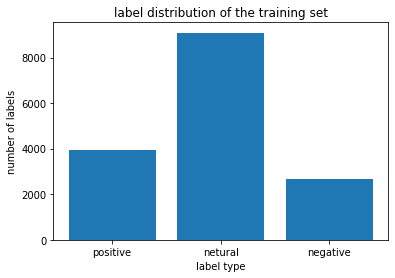

In [5]:
#Count label distribution of training data
counter = dict(collections.Counter(y_train))
label = ['positive','netural','negative']
data = [counter['positive'],counter['neutral'],counter['negative']]
plt.bar(label, data)
plt.title('label distribution of the training set')
plt.xlabel('label type')
plt.ylabel('number of labels')
plt.show()

In [6]:
print(counter)

{'neutral': 9088, 'positive': 3925, 'negative': 2684}


In [7]:
print(f'Lenngth of the training data: {len(X_train)}')
print(f'Lenngth of the test data: {len(X_valid)}')

Lenngth of the training data: 15697
Lenngth of the test data: 6105


### Preprocessing: Data cleaning

In [8]:
#This cell remove all unmeaningful characters

#Note：Some of following codes are modified based on the GitHub open sourse repositry#
#Link: https://gist.github.com/jiahao87/d57a2535c2ed7315390920ea9296d79f #

tknzr = TweetTokenizer(strip_handles=True, reduce_len=True) 
ps = nltk.PorterStemmer()
wordnet = nltk.WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')
stopwords = []
# exclude words from stopwords list
for i in stop_words:
    if i != 'not' and i != 'no':
        stopwords.append(i)

def remove_links(text):
    return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
def remove_email(text):
    return re.sub(r'[\.a-zA-Z0-9_-]*@[\.a-zA-Z0-9_-]*', '', text)
def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text

def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text

def remove_num(text):
    return ''.join([i for i in text if not i.isdigit()])

def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text
def remove_stopwords(text):
    return ' '.join([wordnet.lemmatize(i) for i in text.split() if i not in stopwords])

def remove_punc(text):
    return ''.join([i for i in text if i not in punctuation])

def remove_num(text):
    return ''.join([i for i in text if not i.isdigit()])

def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())

def remove_not_alpha(text):
    return re.sub(r'[^\s\.a-zA-Z_-]+', '', text)

def preprocess(text):
    no_email = remove_email(text)
    no_accented_chars = remove_accented_chars(no_email)
    no_links = remove_links(no_accented_chars) 
    no_white_space = remove_whitespace(no_links)
    no_punc = remove_punc(no_white_space)  
    no_contractions = expand_contractions(no_punc)
    no_html_tags = strip_html_tags(no_contractions)
    no_num = remove_num(no_html_tags)
    no_stopwords = remove_stopwords(no_num)
    no_alpha = remove_not_alpha(no_stopwords)
    tok = tknzr.tokenize(no_alpha)
    return " ".join([ps.stem(word) for word in tok])

def preprocess_with_stopwords(text):
    no_email = remove_email(text)
    no_accented_chars = remove_accented_chars(no_email)
    no_links = remove_links(no_accented_chars) 
    no_white_space = remove_whitespace(no_links)
    no_punc = remove_punc(no_white_space)  
    no_contractions = expand_contractions(no_punc)
    no_html_tags = strip_html_tags(no_contractions)
    no_num = remove_num(no_html_tags)
    no_alpha = remove_not_alpha(no_num)
    tok = tknzr.tokenize(no_alpha)
    return " ".join([ps.stem(word) for word in tok])

def prepare(text): 
    res = []
    for line in text:
        line = line.lower()
        line = preprocess(line) 
        res.append(line)    
    return res   
def prepare_with_stopwords(text): 
    res = []
    for line in text:
        line = line.lower()
        line = preprocess_with_stopwords(line) 
        res.append(line)    
    return res    


In [9]:
#Data cleaning
X_train_clean = prepare(X_train)
X_valid_clean = prepare(X_valid) 

In [10]:
X_train_clean_with_stopwords = prepare_with_stopwords(X_train)
X_valid_clean_with_stopwords = prepare_with_stopwords(X_valid) 

### Preprocessing: Vectorization
**Bag of Words (BoW)**

In this approach, we use the **CountVectorizer** library to separate all the words in the Train corpus (dataset). These words are then used as the 'vectors' or 'features' to represent each instance (Tweet) in `Train` and `Test` datasets. 

In [11]:

#Apply BoW to training data
BoW_vectorizer_12 = CountVectorizer(ngram_range=(1,2))
#Build the feature set (vocabulary) and vectorise the Train dataset using BoW
X_train_BoW_12 = BoW_vectorizer_12.fit_transform(X_train_clean)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_valid_BoW_12 = BoW_vectorizer_12.transform(X_valid_clean)
X_valid_BoW_12.shape


(6105, 127768)

In [12]:
#Apply BoW to training data with stopwords
BoW_vectorizer_12_stopwords = CountVectorizer(ngram_range=(1,2))
#Build the feature set (vocabulary) and vectorise the Train dataset using BoW
X_train_BoW_12_stopwords = BoW_vectorizer_12_stopwords.fit_transform(X_train_clean_with_stopwords)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_valid_BoW_12_stopwords = BoW_vectorizer_12_stopwords.transform(X_valid_clean_with_stopwords)
X_valid_BoW_12_stopwords.shape

(6105, 144868)

**TF-IDF**

In this approach, we use the **TfidfVectorizer** library to separate all the words in this corpus (dataset). Same as the BoW approach, these words are then used as the 'vectors' or 'features' to represent each instance (Tweet).

However, in this method for each instance the value associated with each 'vector' (word) is not the number of times the word repeated in that tweet, but the TFIDF value of then 'voctor' (word).

In [13]:

#Apply TF-IDF to training data
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

#Build the feature set (vocabulary) and vectorise the Train dataset using TFIDF
X_train_tfidf_12 = tfidf_vectorizer.fit_transform(X_train_clean)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_valid_tfidf_12 = tfidf_vectorizer.transform(X_valid_clean)

X_valid_tfidf_12.shape


(6105, 127768)

### Preprocessing: feature selection 
**selectKBest + chi2 (Used in the report)** 

In [14]:
#Function of selectKBest with chi2
def chi(k_value):
    selector = SelectKBest(chi2,k=k_value)
    x_train_chi_12 = selector.fit_transform(X_train_BoW_12 ,y_train)
    x_test_chi_12 = selector.transform(X_valid_BoW_12)

    return x_train_chi_12, x_test_chi_12

In [15]:
#Function of selectKBest with chi2
def chi_stopwords(k_value):
    selector = SelectKBest(chi2,k=k_value)
    x_train_chi_12_stopwords = selector.fit_transform(X_train_BoW_12_stopwords ,y_train)
    x_test_chi_12_stopwords = selector.transform(X_valid_BoW_12_stopwords)

    return x_train_chi_12_stopwords, x_test_chi_12_stopwords

### Compare BoW and TFIDF


In [16]:
#Function of TF-IDF with chi2
def Tfidf_chi(k_value, X_train_tfidf,X_valid_tfidf):
    selector = SelectKBest(chi2,k=k_value)
    x_train_chi_Tfidf = selector.fit_transform(X_train_tfidf ,y_train)
    x_test_chi_Tfidf = selector.transform(X_valid_tfidf)

    return x_train_chi_Tfidf , x_test_chi_Tfidf

#Function of BoW with chi2
def BoW_chi(k_value, X_train_BoW,X_valid_BoW ):
    selector = SelectKBest(chi2,k=k_value)
    x_train_chi_Bow = selector.fit_transform(X_train_BoW ,y_train)
    x_test_chi_Bow = selector.transform(X_valid_BoW)

    return x_train_chi_Bow, x_test_chi_Bow


In [17]:
#TFidf vs BoW
LR_BoW_chi = []
LR_tfidf_chi = []
SVM_BoW_chi = []
SVM_tfidf_chi = []
NB_BoW_chi = []
NB_tfidf_chi = []
RF_BoW_chi = []
RF_tfidf_chi = []
for k in range(200,3000,200):
    x_train_chi_Bow, x_test_chi_Bow = BoW_chi(k, X_train_BoW_12, X_valid_BoW_12)
    x_train_chi_Tfidf , x_test_chi_Tfidf = Tfidf_chi(k, X_train_tfidf_12,X_valid_tfidf_12)
    lr1 = LogisticRegression(max_iter=2000).fit(x_train_chi_Bow, y_train)
    LR1_acc = np.mean(cross_val_score(lr1,x_test_chi_Bow,y_valid,cv = 5))
    LR_BoW_chi.append(LR1_acc)
    lr2 = LogisticRegression(max_iter=2000).fit(x_train_chi_Tfidf, y_train)
    LR2_acc = np.mean(cross_val_score(lr2,x_test_chi_Tfidf,y_valid,cv = 5))
    LR_tfidf_chi.append(LR2_acc)
    clf1 = SVC().fit(x_train_chi_Bow, y_train)
    clf1_acc = np.mean(cross_val_score(clf1,x_test_chi_Bow,y_valid,cv = 5))
    SVM_BoW_chi.append(clf1_acc)
    clf2 = SVC().fit(x_train_chi_Tfidf, y_train)
    clf2_acc = np.mean(cross_val_score(clf2,x_test_chi_Tfidf,y_valid,cv = 5))
    SVM_tfidf_chi.append(clf2_acc)
    rf1 = RandomForestClassifier().fit(x_train_chi_Bow, y_train)
    rf1_acc = np.mean(cross_val_score(rf1,x_test_chi_Bow,y_valid,cv = 5))
    RF_BoW_chi.append(rf1_acc)
    rf2 = RandomForestClassifier().fit(x_train_chi_Tfidf, y_train)
    rf2_acc = np.mean(cross_val_score(rf2,x_test_chi_Tfidf,y_valid,cv = 5))
    RF_tfidf_chi.append(rf2_acc)


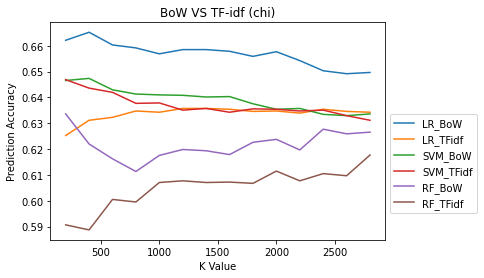

In [18]:
#Plot models with chi2
x = np.arange(200,3000,200)
y1 = np.array(LR_BoW_chi )
y2 = np.array(LR_tfidf_chi)
y3 = np.array(SVM_BoW_chi) 
y4 = np.array(SVM_tfidf_chi)
y5 = np.array(RF_BoW_chi )
y6 = np.array(RF_tfidf_chi)
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
plt.plot(x, y4) 
plt.plot(x, y5)
plt.plot(x, y6)

plt.xlabel("K Value") 
plt.ylabel("Prediction Accuracy") 
plt.title('BoW VS TF-idf (chi)')
plt.legend(['LR_BoW','LR_TFidf', 'SVM_BoW', 'SVM_TFidf','RF_BoW','RF_TFidf'],bbox_to_anchor=(1, 0.60))

**By obsverving the plots, K = 400 and BoW has the best perfermence.**

## Print results
 

In [19]:
x_train_chi, x_valid_chi = chi(400)

#This function print the result of models
def print_result(model, x_train, x_test):
    y_train_predicted = model.predict(x_train)
    ta = accuracy_score(y_train, y_train_predicted)

    print("training accuracy ", ta)
    va = np.mean(cross_val_score(model,x_test,y_valid,cv = 5))
    print('validation accuracy: ' ,va)
    #y_predicted = model.predict(x_test)
    pa = model.score(x_test, y_valid)
    print('prediction accuracy: ', pa)

    y_pred = model.predict(x_test)
    W_precision = precision_score(y_valid, y_pred, average="weighted")
    print('Weighted Precision: %f ' % W_precision)
    W_recall = recall_score(y_valid, y_pred, average="weighted")
    print('Weighted Recall: %f ' % W_recall)
    W_f1 = f1_score(y_valid, y_pred, average="weighted")
    print('Weighted F1 score: %f ' % W_f1)
    cm = confusion_matrix(y_valid, y_pred, labels =model.classes_)
    disp =ConfusionMatrixDisplay(confusion_matrix = cm, display_labels =model.classes_ )
    disp.plot()

    return ta,va,pa,W_precision,W_recall,W_f1

#Empty lists for storing the model's results
ta_chi = []
va_chi = []
pa_chi = []
W_precision_chi = []
W_recall_chi = []
W_f1_chi = []
time_chi = []


# Models

### Model: Zero-R

Excution time of Logtistic Regression classifier: 0.003s

training accuracy  0.578964133273874
validation accuracy:  0.5849303849303849
prediction accuracy:  0.584930384930385
Weighted Precision: 0.342144 
Weighted Recall: 0.584930 
Weighted F1 score: 0.431746 


C:\Users\Lingpeng\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


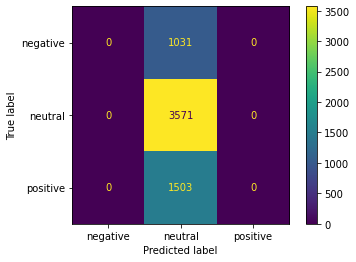

In [20]:
#Zero-R with chi
x_train_chi, x_valid_chi = chi(400)
clf_0R = DummyClassifier(strategy= 'most_frequent')

t0 = time.time()
ZR_chi = clf_0R.fit(x_train_chi,y_train)
t1 = time.time()-t0
print("Excution time of Logtistic Regression classifier: {}s\n". format(round(t1,3)))

ZR_chi.score(x_valid_chi,y_valid)
ta_chi_base,va_chi_base,pa_chi_base,W_precision_chi_base,W_recall_chi_base,W_f1_chi_base = print_result(ZR_chi, x_train_chi,x_valid_chi)


In [21]:
#Add result to relative lists
ta_chi.append(ta_chi_base)
va_chi.append(va_chi_base)
pa_chi.append(pa_chi_base)
W_precision_chi.append(W_precision_chi_base)
W_recall_chi.append(W_recall_chi_base)
W_f1_chi.append(W_f1_chi_base)
time_chi.append(t1)

### Model: Logistic Regression

In [18]:
#Set K = 400 and do grid search
x_train_chi_LR, x_test_chi_LR = chi(400)

def gs_LogisticRegression(x_train):
    parameters_LR = {'solver':('newton-cg','lbfgs','sag','saga'),'C':np.arange(0.1,2.5,0.2),'multi_class':('auto','ovr','multinomial')}
    LR = LogisticRegression(max_iter=2000)
    gs = GridSearchCV(LR,parameters_LR)
    gs.fit(x_train,y_train)

    return gs.best_params_, gs.best_score_


best_estimator_LR, best_score_LR = gs_LogisticRegression(x_train_chi_LR)


In [19]:
print(f"The best estimators are: {best_estimator_LR}")
print(f"The best score is: {best_score_LR}")

The best estimators are: {'C': 2.1000000000000005, 'multi_class': 'auto', 'solver': 'saga'}
The best score is: 0.6761804136576418


In [22]:
#Function of logistic regression
def logistic_regression(k_value, c_value):
    x_train_chi_final_LR, x_test_chi_final_LR = chi(k_value)
    LR = LogisticRegression(solver= 'saga', C = c_value, max_iter = 2000).fit(x_train_chi_final_LR, y_train)
    y_train_predicted = LR.predict(x_train_chi_final_LR)
    LR_acc = np.mean(cross_val_score(LR,x_test_chi_final_LR,y_valid,cv = 5))

    return np.mean(y_train_predicted == y_train), LR_acc, LR.score(x_test_chi_final_LR, y_valid)


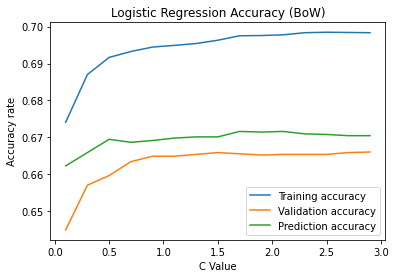

In [23]:
#Accuracy when K = 400
#Print Logistic regression's accuracy with different C
training_accuracy_list_LR = []
validation_accuracy_list_LR = []
prediction_accuracy_list_LR = []


for i in range(1,30,2):
    ta, va, pa = logistic_regression(400, i/10)
    training_accuracy_list_LR.append(ta)
    validation_accuracy_list_LR.append(va)
    prediction_accuracy_list_LR.append(pa)

x = np.arange(0.1,3.0,0.2) 
y1 = np.array(training_accuracy_list_LR)
y2 = np.array(validation_accuracy_list_LR)
y3 = np.array(prediction_accuracy_list_LR)

# PLot
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
# Add Title
plt.title("Logistic Regression Accuracy (BoW)") 
# Add Axes Labels and legend
plt.xlabel("C Value") 
plt.ylabel("Accuracy rate") 
plt.legend(['Training accuracy','Validation accuracy', 'Prediction accuracy'])
# Display
plt.show()

**C = 1.4: Highest validation accuracy**

**C = 2.1: Highest prediction accuracy**

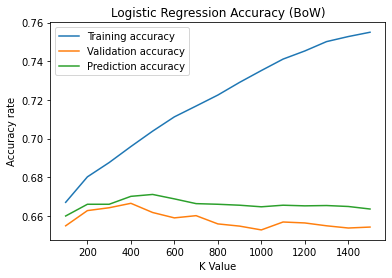

In [24]:
#Accuracy when c = 1.4
#Plot Logistic regression's accuracy with different k
training_accuracy_list_LR = []
validation_accuracy_list_LR = []
prediction_accuracy_list_LR = []


for i in range(100,1600,100):
    ta, va, pa = logistic_regression(i,1.4)
    training_accuracy_list_LR.append(ta)
    validation_accuracy_list_LR.append(va)
    prediction_accuracy_list_LR.append(pa)

x = np.arange(100,1600,100) 
y1 = np.array(training_accuracy_list_LR)
y2 = np.array(validation_accuracy_list_LR)
y3 = np.array(prediction_accuracy_list_LR)
# PLot
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
# Add Title
plt.title("Logistic Regression Accuracy (BoW)") 

# Add Axes Labels and legend
plt.xlabel("K Value") 
plt.ylabel("Accuracy rate") 
plt.legend(['Training accuracy','Validation accuracy', 'Prediction accuracy'])
# Display
plt.show()

Excution time of Logtistic Regression classifier: 0.259 s

training accuracy  0.695865451997197
validation accuracy:  0.6665028665028665
prediction accuracy:  0.6701064701064701
Weighted Precision: 0.665460 
Weighted Recall: 0.670106 
Weighted F1 score: 0.646076 


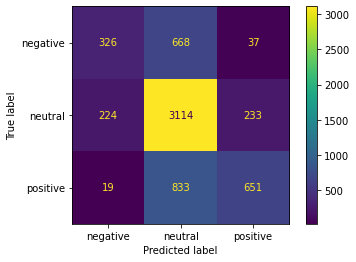

In [25]:
#Final model with chi2
x_train_chi, x_valid_chi = chi(400)

t0 = time.time()
LR_final_chi = LogisticRegression(solver= 'saga', C = 1.4, max_iter = 2000).fit(x_train_chi, y_train)
t1 = time.time()-t0
print("Excution time of Logtistic Regression classifier: {} s\n". format(round(t1,3)))

ta_chi_LR,va_chi_LR,pa_chi_LR,W_precision_chi_LR,W_recall_chi_LR,W_f1_chi_LR = print_result(LR_final_chi, x_train_chi, x_valid_chi)


In [26]:
#Add results to relative lists
ta_chi.append(ta_chi_LR)
va_chi.append(va_chi_LR)
pa_chi.append(pa_chi_LR)
W_precision_chi.append(W_precision_chi_LR)
W_recall_chi.append(W_recall_chi_LR)
W_f1_chi.append(W_f1_chi_LR)
time_chi.append(t1)

Excution time of Logtistic Regression classifier: 0.354 s

training accuracy  0.6962476906415238
validation accuracy:  0.6588042588042589
prediction accuracy:  0.6673218673218673
Weighted Precision: 0.662920 
Weighted Recall: 0.667322 
Weighted F1 score: 0.643884 


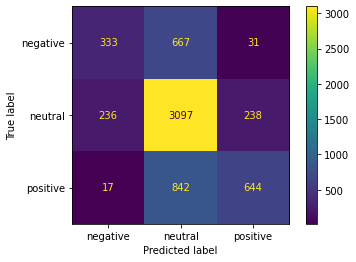

In [27]:
#model without stopwords
x_train_chi_stopwords, x_valid_chi_stopwords = chi_stopwords(400)

t0 = time.time()
LR_final_chi = LogisticRegression(solver= 'saga', C = 1.4, max_iter = 2000).fit(x_train_chi_stopwords, y_train)
t1 = time.time()-t0
print("Excution time of Logtistic Regression classifier: {} s\n". format(round(t1,3)))

ta_chi_LR_s,va_chi_LR_s,pa_chi_LR_s,W_precision_chi_LR_s,W_recall_chi_LR_s,W_f1_chi_LR_s = print_result(LR_final_chi, x_train_chi_stopwords, x_valid_chi_stopwords)



### Model: SVM



In [26]:
#Do grid search
parameters_svc = {"kernel":('linear', 'poly', 'rbf', 'sigmoid'), "decision_function_shape":('ovo','ovr'), 'C':np.arange(0.1,5.0,0.3)}
gs_svc = GridSearchCV(SVC(), param_grid = parameters_svc)  
gs_svc.fit(x_train_chi, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([0.1, 0.4, 0.7, 1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7,
       4. , 4.3, 4.6, 4.9]),
                         'decision_function_shape': ('ovo', 'ovr'),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')})

In [27]:
print(gs_svc.best_params_)

{'C': 3.1000000000000005, 'decision_function_shape': 'ovo', 'kernel': 'linear'}


In [28]:
#SVC function
def svc(c_value):
    clf = SVC(C = c_value).fit(x_train_chi, y_train)
    y_train_predicted = clf.predict(x_train_chi)
    #print("training accuracy ", np.mean(y_train_predicted == y_train))
    clf_va = np.mean(cross_val_score(clf,x_valid_chi,y_valid,cv = 5))

    return np.mean(y_train_predicted == y_train), clf_va, clf.score(x_valid_chi, y_valid)

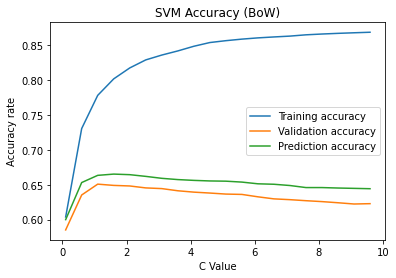

In [29]:
#Accuracy when K = 400
#Plot model results with different C
training_accuracy_list_SVM = []
validation_accuracy_list_SVM = []
prediction_accuracy_list_SVM = []


for i in range(1,100,5):
    ta, va, pa = svc(i/10)
    training_accuracy_list_SVM.append(ta)
    validation_accuracy_list_SVM.append(va)
    prediction_accuracy_list_SVM.append(pa)

x = np.arange(0.1,10.0,0.5) 
y1 = np.array(training_accuracy_list_SVM)
y2 = np.array(validation_accuracy_list_SVM)
y3 = np.array(prediction_accuracy_list_SVM)
# PLot
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
# Add Title
plt.title("SVM Accuracy (BoW)") 

# Add Axes Labels and legend
plt.xlabel("C Value") 
plt.ylabel("Accuracy rate") 
plt.legend(['Training accuracy','Validation accuracy', 'Prediction accuracy'])
# Display
plt.show()

Highest va: c = 0.4

Highest pa: c = 3.1

Excution time of SVM classifier: 5.003s
training accuracy  0.6866917245333504
validation accuracy:  0.6515970515970517
prediction accuracy:  0.6588042588042589
Weighted Precision: 0.649630 
Weighted Recall: 0.658804 
Weighted F1 score: 0.632546 


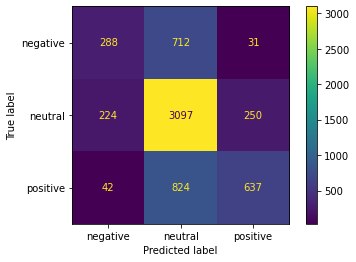

In [30]:
#Final model with chi2
x_train_chi, x_valid_chi = chi(400)

t0 = time.time()
SVM_final_chi = SVC(kernel="linear", C = 0.4, decision_function_shape = 'ovo').fit(x_train_chi, y_train)
t1 = time.time()-t0
print("Excution time of SVM classifier: {}s". format(round(t1,3)))
ta_chi_SVM,va_chi_SVM,pa_chi_SVM,W_precision_chi_SVM,W_recall_chi_SVM,W_f1_chi_SVM = print_result(SVM_final_chi, x_train_chi, x_valid_chi)


In [31]:
#Add results to relative lists
ta_chi.append(ta_chi_SVM)
va_chi.append(va_chi_SVM)
pa_chi.append(pa_chi_SVM)
W_precision_chi.append(W_precision_chi_SVM)
W_recall_chi.append(W_recall_chi_SVM)
W_f1_chi.append(W_f1_chi_SVM)
time_chi.append(t1)

Excution time of Logtistic Regression classifier: 9.473 s

training accuracy  0.6856724214818118
validation accuracy:  0.6479934479934479
prediction accuracy:  0.6596232596232596
Weighted Precision: 0.654516 
Weighted Recall: 0.659623 
Weighted F1 score: 0.630524 


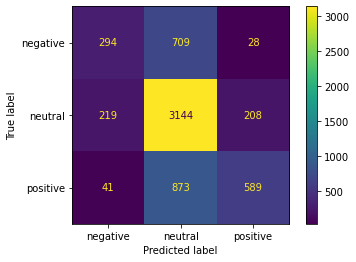

In [32]:
#Model without stopwords
x_train_chi_stopwords, x_valid_chi_stopwords = chi_stopwords(400)

t0 = time.time()
SVM_final_chi = SVC(kernel="linear", C = 0.4, decision_function_shape = 'ovo').fit(x_train_chi_stopwords, y_train)
t1 = time.time()-t0
print("Excution time of Logtistic Regression classifier: {} s\n". format(round(t1,3)))

ta_chi_SVM_s,va_chi_SVM_s,pa_chi_SVM_s,W_precision_chi_SVM_s,W_recall_chi_SVM_s,W_f1_chi_SVM_s = print_result(SVM_final_chi, x_train_chi_stopwords, x_valid_chi_stopwords)

### Model: Random Forest

In [33]:
#Do grid search
x_train_chi_RF, x_test_chi_RF = chi(400)
parameters_RF = {"n_estimators":[100,150,200,250,300,350,400], "criterion": ('gini', 'entropy'), "max_depth":[40,50,60,70], "min_samples_split":[2,3,4,5,6], "min_samples_leaf":[1,2,3,4,5]}
gs_RF = GridSearchCV(RandomForestClassifier(), param_grid = parameters_RF)  
gs_RF.fit(x_train_chi_RF, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [40, 50, 60, 70],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5, 6],
                         'n_estimators': [100, 150, 200, 250, 300, 350, 400]})

In [34]:
gs_RF.best_estimator_

RandomForestClassifier(max_depth=70, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=250)

In [33]:
#Change max_depth and plot the accuracy
x_train_chi, x_valid_chi = chi(400)
lt = []
lv = []
lp = []
for i in range(10,500,40):
    rf = RandomForestClassifier(min_samples_leaf=2, max_depth=i, n_estimators=250, min_samples_split=3).fit(x_train_chi, y_train)
    y_train_predicted = rf.predict(x_train_chi)
    clf_va = np.mean(cross_val_score(rf,x_valid_chi,y_valid,cv = 5))
    ta = np.mean(y_train_predicted == y_train)
    va = clf_va
    pa = rf.score(x_valid_chi, y_valid)
    lt.append(ta)
    lv.append(va)
    lp.append(pa)
x = np.arange(10,500,40) 
y1 = np.array(lt)
y2 = np.array(lv)
y3 = np.array(lp)


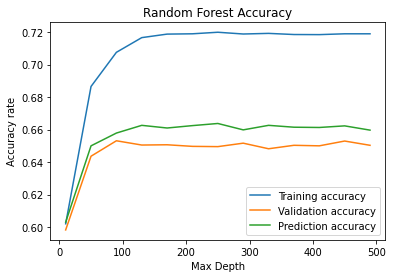

In [34]:
# PLot
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
# Add Title
plt.title("Random Forest Accuracy") 

# Add Axes Labels and legend
plt.xlabel("Max Depth") 
plt.ylabel("Accuracy rate") 
plt.legend(['Training accuracy','Validation accuracy', 'Prediction accuracy'])
# Display
plt.show()

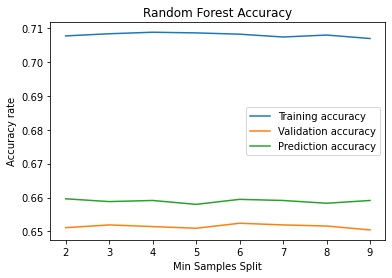

In [35]:
#Change min_sample_leaf and plot the accuracy
x_train_chi, x_valid_chi = chi(400)
lt = []
lv = []
lp = []
for i in range(2,10,1):
    rf = RandomForestClassifier(min_samples_leaf=2, max_depth=90, n_estimators=250,min_samples_split=i ).fit(x_train_chi, y_train)
    y_train_predicted = rf.predict(x_train_chi)
    clf_va = np.mean(cross_val_score(rf,x_valid_chi,y_valid,cv = 5))
    ta = np.mean(y_train_predicted == y_train)
    va = clf_va
    pa = rf.score(x_valid_chi, y_valid)
    lt.append(ta)
    lv.append(va)
    lp.append(pa)
x = np.arange(2,10,1) 
y1 = np.array(lt)
y2 = np.array(lv)
y3 = np.array(lp)
# PLot
plt.plot(x, y1) 
plt.plot(x, y2)
plt.plot(x, y3)
# Add Title
plt.title("Random Forest Accuracy") 

# Add Axes Labels and legend
plt.xlabel("Min Samples Split") 
plt.ylabel("Accuracy rate") 
plt.legend(['Training accuracy','Validation accuracy', 'Prediction accuracy'])
# Display
plt.show()


Excution time of Random Forest classifier: 2.11s
training accuracy  0.7084156208192648
validation accuracy:  0.6527436527436528
prediction accuracy:  0.6573300573300573
Weighted Precision: 0.648595 
Weighted Recall: 0.657330 
Weighted F1 score: 0.623322 


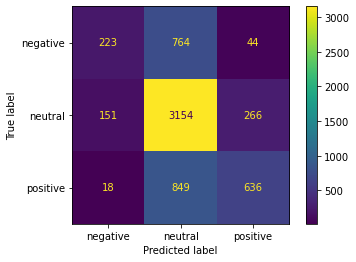

In [36]:
#Final model with chi2
x_train_chi, x_valid_chi = chi(400)

t0 = time.time()
RF_final_chi = RandomForestClassifier(max_depth=90, min_samples_leaf=2, n_estimators=250).fit(x_train_chi, y_train)
t1 = time.time()-t0
print("Excution time of Random Forest classifier: {}s". format(round(t1,3)))

#Add results to relative lists
ta_chi_RF,va_chi_RF,pa_chi_RF,W_precision_chi_RF,W_recall_chi_RF,W_f1_chi_RF = print_result(RF_final_chi, x_train_chi, x_valid_chi)
ta_chi.append(ta_chi_RF)
va_chi.append(va_chi_RF)
pa_chi.append(pa_chi_RF)
W_precision_chi.append(W_precision_chi_RF)
W_recall_chi.append(W_recall_chi_RF)
W_f1_chi.append(W_f1_chi_RF)
time_chi.append(t1)

### Model: Stacking

In [37]:
#Set up Stacking model
x_train_chi, x_valid_chi = chi(400)

estimator = [('lr', LogisticRegression(solver= 'saga', C = 1.4, max_iter = 2000)),
            #('svc', SVC(kernel="linear", C = 0.4,decision_function_shape = 'ovo')),
            ('RF', RandomForestClassifier(max_depth=90, min_samples_leaf=2, n_estimators=250))
            ]
clf2 = StackingClassifier(estimators= estimator, final_estimator=LogisticRegression(max_iter=2000))


Excution time of Stacking classifier: 12.372 s
training accuracy  0.7075874370898898
validation accuracy:  0.6673218673218673
prediction accuracy:  0.6722358722358722
Weighted Precision: 0.667325 
Weighted Recall: 0.672236 
Weighted F1 score: 0.649836 


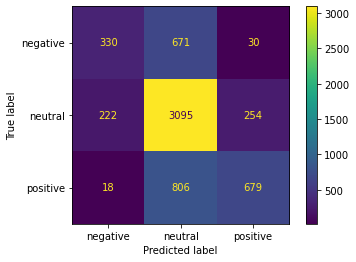

In [38]:
#Final model with chi2
t0 = time.time()
S_final_chi = clf2.fit(x_train_chi, y_train)
t1 = time.time()-t0
print("Excution time of Stacking classifier: {} s". format(round(t1,3)))

ta_chi_S,va_chi_S,pa_chi_S,W_precision_chi_S,W_recall_chi_S,W_f1_chi_S = print_result(S_final_chi, x_train_chi, x_valid_chi)


In [39]:
#Add results to relative lists
ta_chi.append(ta_chi_S)
va_chi.append(va_chi_S)
pa_chi.append(pa_chi_S)
W_precision_chi.append(W_precision_chi_S)
W_recall_chi.append(W_recall_chi_S)
W_f1_chi.append(W_f1_chi_S)
time_chi.append(t1)

In [40]:
#Make dataset with model's results
chi_list = []
chi_columns = []
chi_index = []
chi_list.append(ta_chi)
chi_list.append(va_chi)
chi_list.append(pa_chi)
chi_list.append(W_precision_chi)
chi_list.append(W_recall_chi)
chi_list.append(W_f1_chi)
chi_list.append(time_chi)
chi_columns = ['Base-line','LR', 'SVM','RF', 'S']
chi_index = ['Training Accuracy', 'Validation Accuray', 'Prediction Accuracy', 
'Weighted Precision', 'Weighted Recall', 'Weighted F1-score', 'Execute time(s)']
chi_np_list = np.array(chi_list)
chi_df = pd.DataFrame(chi_np_list,columns=chi_columns, index = chi_index)



In [41]:
#Print results
print("Chi2")
display(chi_df)


Chi2


,Base-line,LR,SVM,RF,S
Training Accuracy,0.578964,0.695865,0.686692,0.708416,0.707587
Validation Accuray,0.584930,0.666503,0.651597,0.652744,0.667322
Prediction Accuracy,0.584930,0.670106,0.658804,0.657330,0.672236
Weighted Precision,0.342144,0.665460,0.649630,0.648595,0.667325
Weighted Recall,0.584930,0.670106,0.658804,0.657330,0.672236
Weighted F1-score,0.431746,0.646076,0.632546,0.623322,0.649836
Execute time(s),0.003006,0.259035,5.002994,2.110214,12.371945


### Final Prediction

In [43]:
#preprocessing
test_data = pd.read_csv("Test.csv", sep=',')
test = test_data['text']
x_test = prepare(test)

In [45]:
X_test_BoW_12 = BoW_vectorizer_12.transform(x_test)
selector = SelectKBest(chi2,k=400)
x_train_chi_12 = selector.fit_transform(X_train_BoW_12 ,y_train)
x_test_12 = selector.transform(X_test_BoW_12)
X_valid_chi = selector.transform(X_valid_BoW_12)

In [46]:
#Output prediction data as .csv file
y_predicted_LR = LR_final_chi.predict(x_test_12)
l_LR = pd.DataFrame(y_predicted_LR, columns= ['sentiment'])
result_LR = pd.concat([test_data["id"],l_LR], axis = 1)
result_LR.to_csv("prediction_LR.csv", index = None)

In [47]:
#Output prediction data as .csv file
y_predicted_S = S_final_chi.predict(x_test_12)
l_S = pd.DataFrame(y_predicted_S, columns= ['sentiment'])
result_S = pd.concat([test_data["id"],l_S], axis = 1)
result_S.to_csv("prediction_S.csv", index = None)


In [48]:
#Output prediction data as .csv file
y_predicted_RF = RF_final_chi.predict(x_test_12)
l_RF = pd.DataFrame(y_predicted_RF, columns= ['sentiment'])
result_RF = pd.concat([test_data["id"],l_RF], axis = 1)
result_RF.to_csv("prediction_RF.csv", index = None)

### Extra: Test the models with the even data distribution

In [47]:
#Randomly extract 2000 instances from each label. And concate them together.
train_data = pd.read_csv("Train.csv", sep=',')
positive_train_data = train_data[train_data['sentiment']=='positive']
X1 = positive_train_data["text"]
y1 =positive_train_data["sentiment"]
X1_train,X1_valid,y1_train,y1_valid = train_test_split(X1,y1,train_size = 2000, test_size= 1715, random_state=30027)

netural_train_data = train_data[train_data['sentiment']=='neutral']
X2 = netural_train_data["text"]
y2 =netural_train_data["sentiment"]
X2_train,X2_valid,y2_train,y2_valid = train_test_split(X2,y2,train_size = 2000, test_size= 1715, random_state=30027)

negative_train_data = train_data[train_data['sentiment']=='negative']
X3 = negative_train_data["text"]
y3 =negative_train_data["sentiment"]
X3_train,X3_valid,y3_train,y3_valid = train_test_split(X3,y3,train_size = 2000, test_size= 1715, random_state=30027)

X_train,X_valid,y_train,y_valid = pd.concat([X1_train,X2_train,X3_train]),pd.concat([X1_valid,X2_valid,X3_valid]),pd.concat([y1_train,y2_train,y3_train]),pd.concat([y1_valid,y2_valid,y3_valid])

In [48]:
#Clean data
x_train_even = prepare(X_train)
x_valid_even = prepare(X_valid)

In [49]:
#Apply BoW
BoW_vectorizer_12 = CountVectorizer(ngram_range=(1,2))
#Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
X_train_BoW_12_even = BoW_vectorizer_12.fit_transform(x_train_even)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_valid_BoW_12_even = BoW_vectorizer_12.transform(x_valid_even)
X_valid_BoW_12_even.shape

(5145, 56716)

In [50]:
#Apply chi2
selector = SelectKBest(chi2,k= 400)
x_train_chi_12 = selector.fit_transform(X_train_BoW_12_even ,y_train)
x_valid_chi_12 = selector.transform(X_valid_BoW_12_even)

Excution time of SVM classifier: 0.936 s
training accuracy  0.6753333333333333
validation accuracy:  0.5797862001943634
prediction accuracy:  0.5885325558794946
Weighted Precision: 0.617436 
Weighted Recall: 0.588533 
Weighted F1 score: 0.594749 


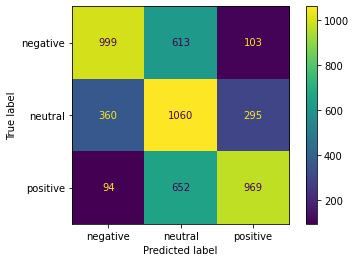

In [51]:
#Print the confusion matrix
t0 = time.time()
SVM_final_chi = SVC(kernel="linear", C = 0.4, decision_function_shape = 'ovo').fit(x_train_chi_12, y_train)
t1 = time.time()-t0
print("Excution time of SVM classifier: {} s". format(round(t1,3)))
ta_chi_SVM,va_chi_SVM,pa_chi_SVM,W_precision_chi_SVM,W_recall_chi_SVM,W_f1_chi_SVM = print_result(SVM_final_chi, x_train_chi_12, x_valid_chi_12)
